In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz
import seaborn as sns

Coin flipping in pymc

In [2]:
np.random.seed(123)

theta_real = 0.35
trials = 4
data = pz.Binomial(n=1, p=theta_real).rvs(trials) # a single coin toss done 4 times (4 trials)

In [3]:
data


array([1, 0, 0, 0], dtype=int64)

<Axes: >

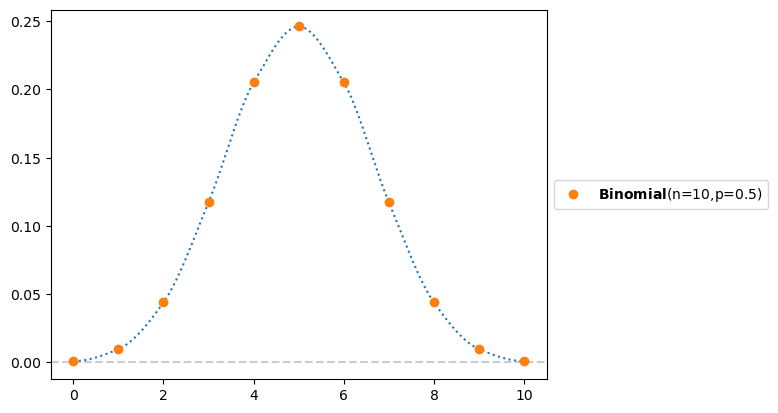

In [4]:
pz.Binomial(n=10, p=0.5).plot_pdf() # 10 coin tosses

* We will use a binomial distribution for the likelihood with parameters n=1 and p=theta
* We will use a Beta prior with alpha=1, beta=1 (uniform)

\begin{aligned}
\theta &\sim \text{Beta}(\alpha=1, \beta=1) \\
Y &\sim \text{Binomial}(n=1, p=\theta)
\end{aligned}


In [ ]:
with pm.Model() as coin_flipping_model:
    # prior
    theta = pm.Beta(name="theta", alpha=1, beta=1)
    # likelihood
    Y = pm.Binomial(name="Y", n=1, p=theta, observed=data)
    
    inference_coin_flipping = pm.sample(1000, chains=4, cores=4, random_seed=4591)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

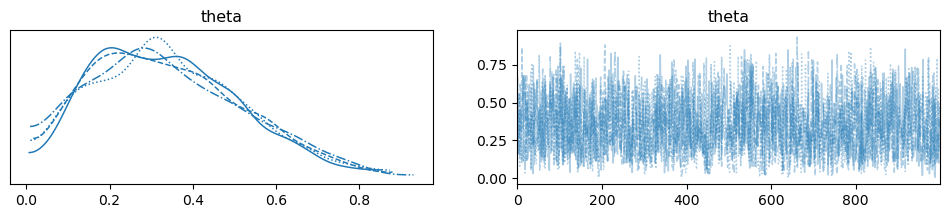

In [ ]:
az.plot_trace(inference_coin_flipping)

* On the left KDE Plot for all 4 chains:
    * Ideally all chains should have a simmilar KDE 

array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

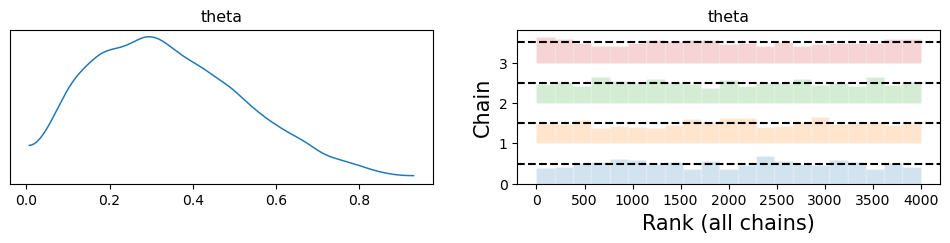

In [ ]:
az.plot_trace(inference_coin_flipping, combined=True, kind="rank_bars") # A single kde plot for all 4 chains and rank plot

* We want the histograms for all chains to be as uniform as possible
    * Large deviations from uniformity signal that chains are exploring different regions of the posterior distribution, we want all chains to explore the entire distribution.

In [ ]:
az.summary(data=inference_coin_flipping, kind="stats").round(2)

,mean,sd,hdi_3%,hdi_97%
theta,0.34,0.18,0.04,0.67


<Axes: title={'center': 'theta'}>

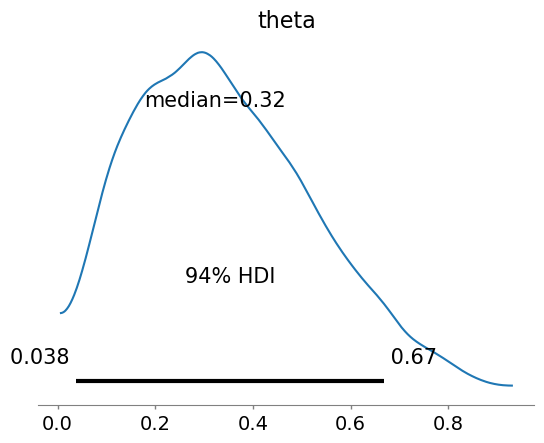

In [ ]:
az.plot_posterior(inference_coin_flipping, point_estimate="median") # we can choose central tendency measure with point_estimate param

Posterior based decisions: reducing continous estimates to binary decisions:
* In our case: Is the coin fair?
    * Our 94 % HDI suggests that we cant rule out the possibilty that it is fair, however more data or a more informative prior would be appreciated.

One way to evaluate how much support the posterior provides for a given value is to compare prior and posterior densities at that value
* Savage-Dickey Density Ratio:

In [10]:
np.random.uniform(0,1, 10000).mean()

0.4983244873393786

In [11]:
pz.Beta(1,1).rvs(10000).mean()

0.5032566928208831

({'BF10': 0.7669613585634284, 'BF01': 1.3038466525524428},
 <Axes: title={'center': 'The BF_10 is 0.77\nThe BF_01 is 1.30'}, xlabel='theta', ylabel='Density'>)

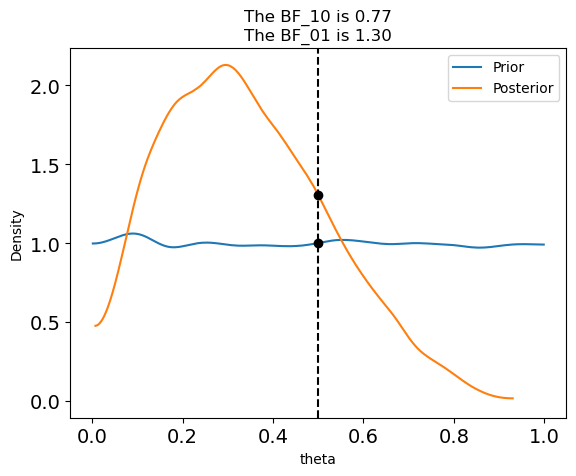

In [12]:
az.plot_bf(inference, var_name="theta", prior=pz.Beta(1,1).rvs(10000), ref_val=0.5)

* BF_01 = 1.25: The value for theta = 0.5 (ref_val) is 1.25 times more likely under the posterior distribution than under prior distribution 
* These are Bayes Factors. And we get them by dividing the height of posterior theta at 0.5 and prior theta at 0.5 => 1.25/1 = 1.25
    * And the value of BF_10 is just the inverse of 1.25/1: 

In [13]:
1/1.25

0.8

* We can think of BF_10 = 0.5 as the value for theta != 0.5 is 0.76 times more likely under the posterior than the prior

Region of practical equivalence (ROPE)
* we know that P(theta)=0.5 is 0, because its a continous variable
* we care about ranges and here we call them regions of practical equivalence
* We can set it at 0.45 to 0.55 for our fair coin problem.
* We can get 3 scenarios:   
    * ROPE doesnt overlap HDI
    * ROPE overlaps HDI fully
    * ROPE overlaps HDI from one side only
* ROPE is arbitrary should be chosen before perfoming analysis and should be chosen based on domain knowledge. If ROPE is covering the entire range of plausible parameter values we dont need to collect any data or perform any inference to reach a conclusion supporting our hypothesis. Say if we chose ROPE for theta parameter to be between 0 and 1 we would always concluded the coin to be fair

We can use arviz to show ROPE when plotting the posterior

<Axes: title={'center': 'theta'}>

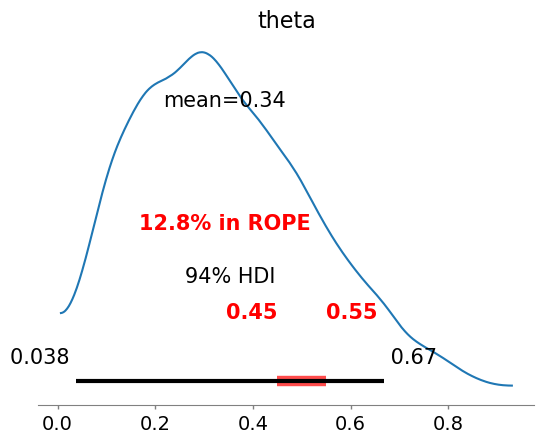

In [14]:
az.plot_posterior(inference, rope=[0.45, 0.55], rope_color="red")

* 12 % of the posterior distribution is covered by our region of practical equivalence, we wouldnt be keen on rejecting the hypothesis of our coin being fair

We can also plot the posterior against a reference value

<Axes: title={'center': 'theta'}>

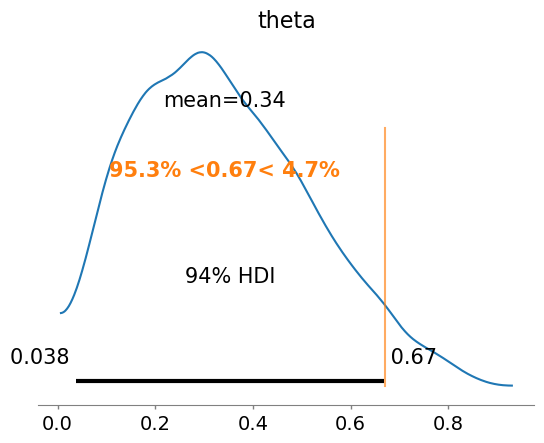

In [15]:
az.plot_posterior(inference, ref_val=0.67)

In [16]:
theta_posterior = inference['posterior']['theta'].to_numpy().reshape(-1)

<Axes: >

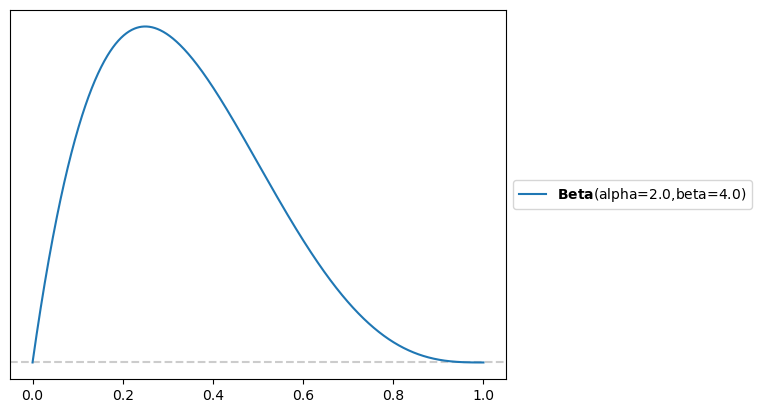

In [17]:
pz.Beta(alpha=1+1, beta=1+3).plot_pdf()

#### Loss functions
* We are plotting the absolute loss (lossf_a) and quadriatic loss (lossf_b) for different values of theta (grid)

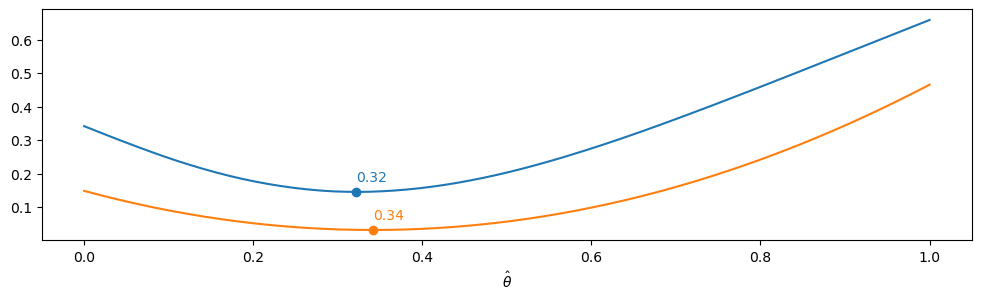

In [18]:
grid = np.linspace(0, 1, 200)
θ_pos = inference.posterior['theta'].to_numpy().reshape(-1)
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]

_, ax = plt.subplots(figsize=(12, 3))
for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = np.argmin(lossf)
    ax.plot(grid, lossf, c)
    ax.plot(grid[mini], lossf[mini], 'o', color=c)
    ax.annotate('{:.2f}'.format(grid[mini]),
    (grid[mini], lossf[mini] + 0.03), color=c)

    # ax.set_yticks([])
    ax.set_xlabel(r'$\hat \theta$')


* These thetas are different point estimates
* The blue line is the absolute loss function and 0.32 is equivalent to the median of the posterior
* orange is the quadriatic loss functon and 0.34 is equivalent to the mean of the posterior

In [19]:
np.mean(theta_posterior)

0.3416474918356881

In [20]:
np.median(theta_posterior)

0.32320656765050404

Some weird loss function example where the cost of making a decision is asymetric, we can define our own loss functions 

In [21]:
lossf = []
for i in grid:
    if i < 0.5:
        f = 1/np.median(θ_pos / np.abs(i**2 - θ_pos))
    else:
        f = np.mean((i - θ_pos)**2 + np.exp(-i)) - 0.25
    lossf.append(f)

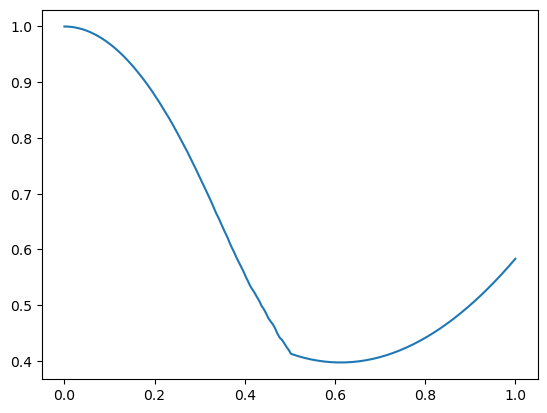

In [22]:
plt.plot(grid, lossf)

In [23]:
data = np.loadtxt("../code/data/chemical_shifts.csv")

<Axes: >

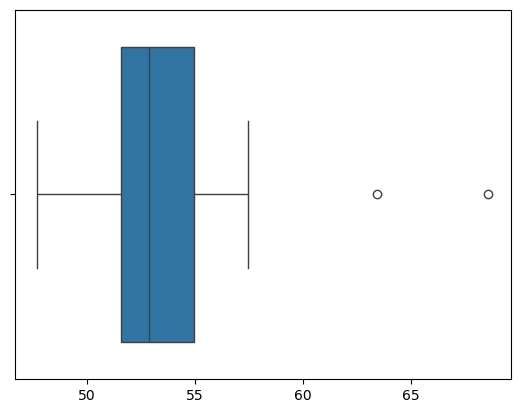

In [24]:
sns.boxplot(data, orient="h")

<Axes: >

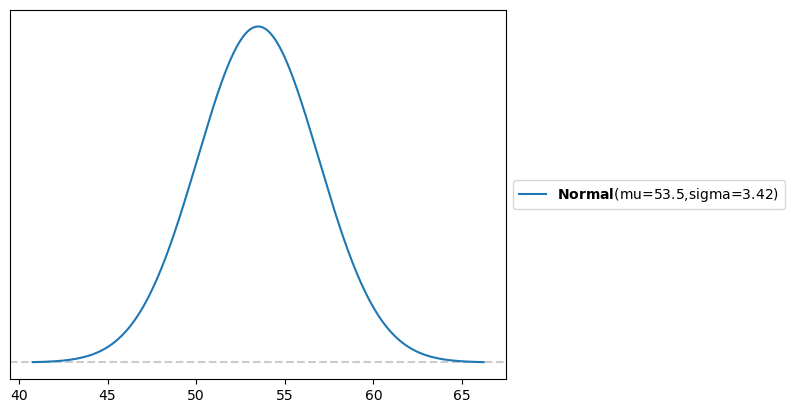

In [25]:
mean = np.mean(data)
std = np.std(data)

pz.Normal(mu=mean, sigma=std).plot_pdf()

Bayesian estimator of mu and sigma:

mu ~ Uniform(40, 70)

sigma ~ HalfNormal(5)

Y ~ Normal(mu, sigma)

Prior mean we set as distributed uniformally between some plausible values according to our data. Here we set is as less than the minimal and more than max value in dataset.

HalfNormal distribution is a good prior for sigma because it has non-negative values centered around 0

Text(0.5, 1.0, 'Prior for mu')

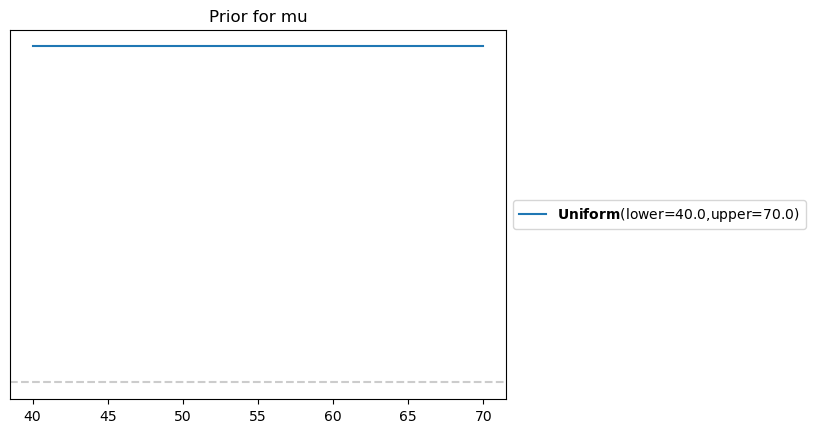

In [26]:
pz.Uniform(40,70).plot_pdf(); plt.title("Prior for mu")

Text(0.5, 1.0, 'Prior for sigma')

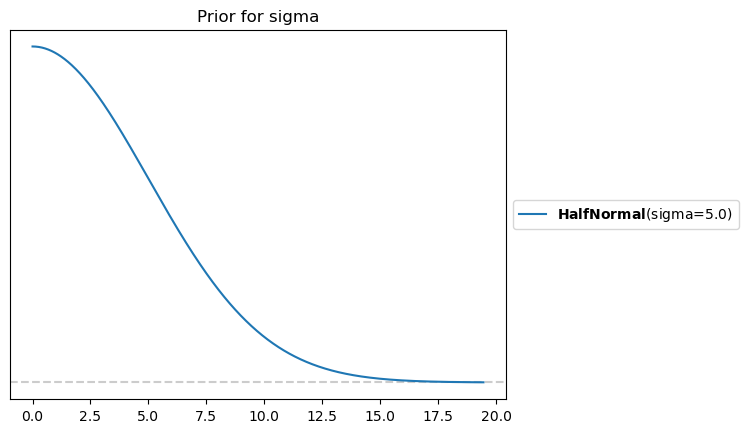

In [27]:
pz.HalfNormal(sigma=5).plot_pdf(); plt.title("Prior for sigma")

In [28]:
with pm.Model() as model:
    # priors
    mu = pm.Uniform(name="mu", lower=40, upper=70)
    sigma = pm.HalfNormal(name="sigma", sigma=5)
    # likelihood
    Y = pm.Normal(name="Y", mu=mu, sigma=sigma, observed=data)
    
    inference = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

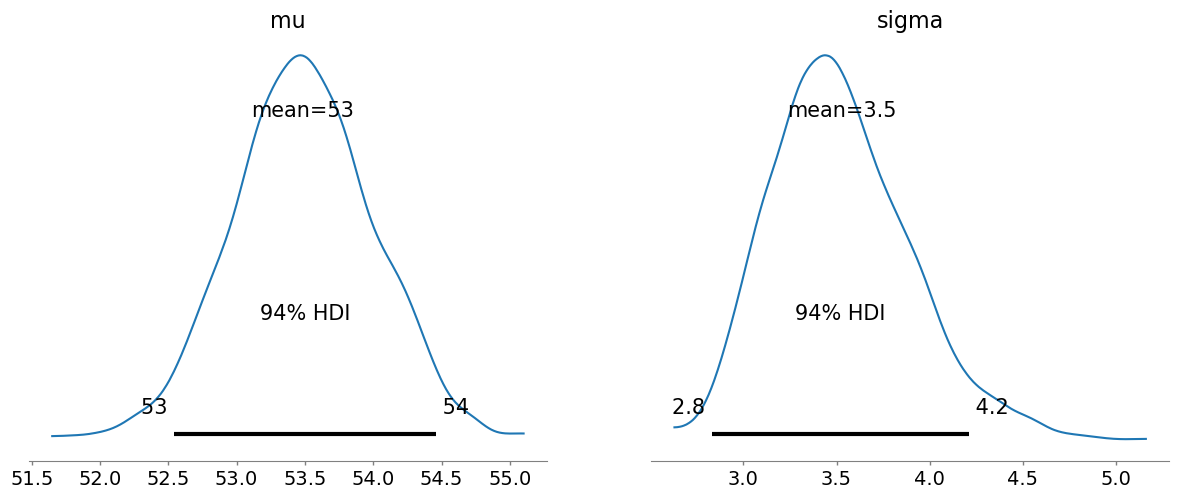

In [29]:
az.plot_posterior(inference)

Trying different priors

In [30]:
with pm.Model() as model:
    # priors
    mu = pm.Uniform(name="mu", lower=0, upper=100)
    sigma = pm.Exponential(name="sigma", lam=0.1)
    # likelihood
    Y = pm.Normal(name="Y", mu=mu, sigma=sigma, observed=data)
    
    inference = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

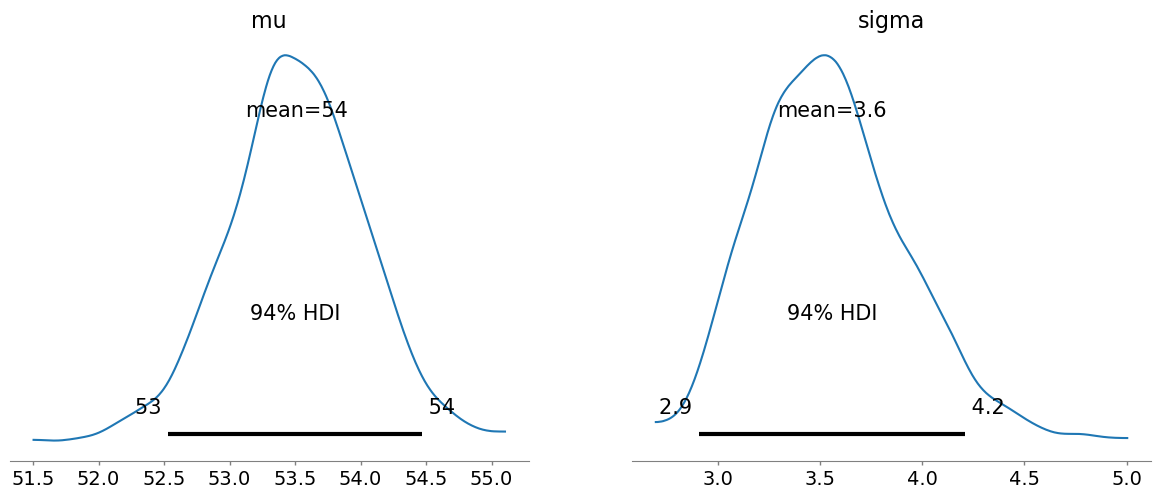

In [31]:
az.plot_posterior(inference)

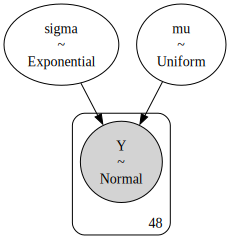

In [32]:
pm.model_to_graphviz(model=model)

We have a bidimensional posterior in our example. I think it just means we have 2 estimated parameters
* We can use arviz function az.plot_pair()

array([[<Axes: >, None],
       [<Axes: xlabel='mu', ylabel='sigma'>, <Axes: >]], dtype=object)

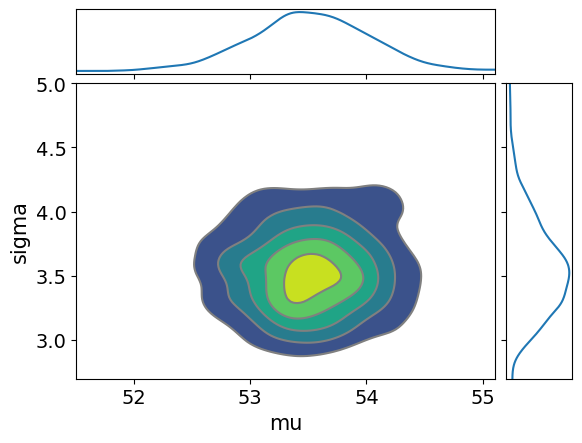

In [33]:
az.plot_pair(data=inference,marginals=True, kind="kde")

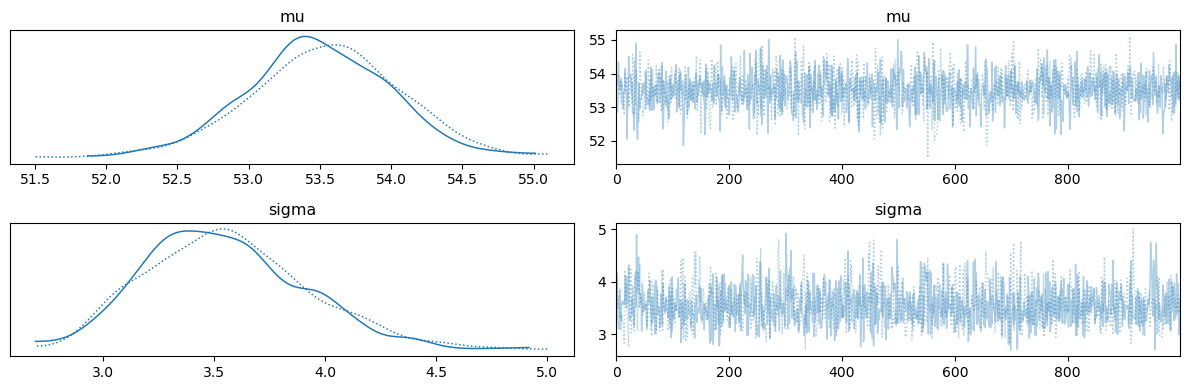

In [82]:
az.plot_trace(inference); plt.tight_layout()

In [34]:
az.summary(data=inference,kind="stats")

,mean,sd,hdi_3%,hdi_97%
mu,53.511,0.518,52.528,54.466
sigma,3.557,0.364,2.906,4.209


#### Posterior predictive checks
* We can generate predictions posterior(y^)
* because we have posterior(param|Y)
* We can use the posterior predictive distributions to do that. 
    * We can think of it as the prediction of future data, given our model and the observed data

In [35]:
pm.sample_posterior_predictive(trace=inference, model=model, extend_inferencedata=True)

Sampling: [Y]


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Posterior predictive checks
* Set of tests to see if the model is a good fit for the data

<Axes: xlabel='Y / Y'>

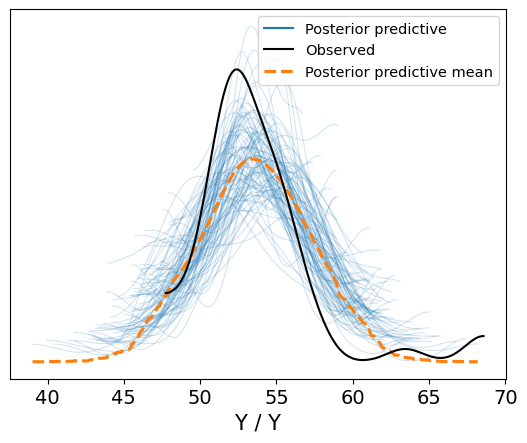

In [36]:
az.plot_ppc(data=inference, num_pp_samples=100)

* Black line is our observed data KDE
* Each blue line is a KDE computed from one of the 100 posterior predictive samples
* Blue lines reflect the uncertainty we have about the distribution of the predicted data
* Hairy and wonky looking kdes will happen with few data points
* **each posterior predictive distribution (each kde) is a like a prediction (predictive distribution) for a single data point**
    * And so we can asses how well the model predicts, how closely the predictive distribution matches the actual distribution
* In the above plot, the mean of the posterior predictive distribution is slightly skewed to the left and the variance is also larger.
    * The source of this discrepancy is attributed to our choice of likelihood and the 2 outlying points to the right of the distribution

And so the question remains
* Is our model good or do we need a different one?
    * Depends, its ok, but we can do better


#### Robust Inferences

* Assuming a normal distribution for the likelihood, we assume not a lot of points in the far tails of the distribution
* Normal distribution is surprised by seeing these two outlying points and the model reacts by moving the mean towards these points and increasing standard deviation

As we can we can blame the data, remove outliers using various techinques, but we can also blame the model and avoid discarding valid data points

In bayesian statistics its preffered to encode assumptions directly in the model, that is by using differenct priors and likelihoods, rather than through heurestic outlier removal rules.

In our example we can try Student-t distribution given it has a simmilar shape with fatter tails. I suspect a SkewNormal distribution would also work.
* Student-t has a DOF parameter (v). Here it's called the degrees of normality. (I like it as the more degrees of normality the more "normal" StudentT distribution becomes.)
* v can go from 0 to infinity, once again the lower the value of v the more probable values away from the mean are. The lower the value of v the higher the kurtosis (4th moment)
    * side note on kurtosis - > While skeweness (3rd moment) measures how asymetric a distribion is and it can be left or right skewed, kurtosis (4th moment) measures the *tailedness* so like how fat are the tails of the distribution and its oblivious to left or right.
    * A high-kurtosis distribution has extreme values (outliers) more often.
    * A low-kurtosis distribution has thinner tails (less extreme values).

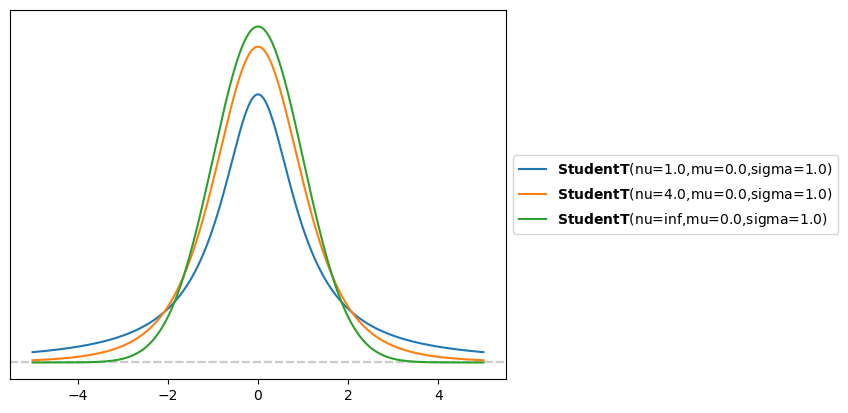

In [58]:
vs = [1,4, np.inf]

for v in vs:
    pz.StudentT(nu=v,mu=0, sigma=1).plot_pdf(support=(-5, 5))
plt.xticks([-4,-2,0,2,4])
plt.show()

* A student-t distribution with v = 1 mu = 0 sigma = 1 has 95% of its probabilty mass between values -12.7,12.7
* Whereas a normal distribution mu=0, sigma=1 has 95% of probabilty mass between -1.96, 1.96

In [60]:
t_student_dist = pz.StudentT(1,0,1)
lower_bound = t_student_dist.ppf(0.025)
upper_bound = t_student_dist.ppf(0.975)

print(f"95% probability mass is between {lower_bound} and {upper_bound}")

95% probability mass is between -12.706204736432102 and 12.706204736432095


* When v<=1, studentT distribution doesnt have a defined mean
* Any finite sample drawn from such distribution of course allows us to compute the mean, but the distribution itself has an undefined mean
    * This has to do with the thick tails, so when we draw values we keep getting a wandering estimate
* Its also important to note, that variance is only defined when v>2, so the 'scale' parameter is not the same as std for these distributions. scale approaches std when v is large

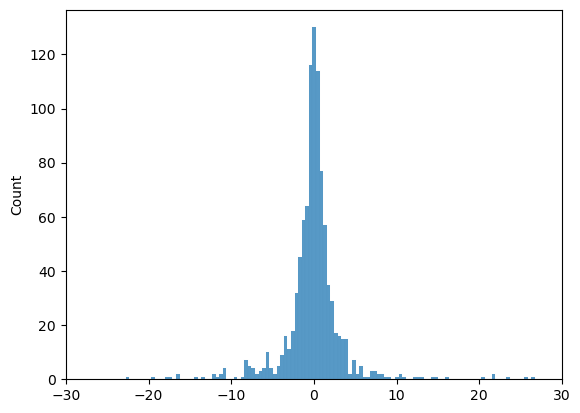

In [74]:
# This is more a showcase of central limit theorem
means=[]
for i in range(1000):
    means.append(t_student_dist.rvs(10000).mean())
    
sns.histplot(means)
plt.xlim(-30, 30)
plt.show()

Now we can rewrite the model using StudentT instead of Normal as our likelihood. This also means we will need one more prior for the new parameter v.

mu ~ Uniform(40, 70)

sigma ~ HalfNormal(10)

v ~ Exponential(1/30)

Y ~ StudentT(mu, sigma, v)

In [80]:
with pm.Model() as student_likelihood_model:
    # priors
    mu = pm.Uniform("mean parameter(mu)", 40, 70)
    sigma = pm.HalfNormal("scale parameter(sigma)",10)
    v = pm.Exponential("degrees of normality(v)", 1/30)
    
    # likelihood
    Y = pm.StudentT("Y", mu=mu, sigma=sigma, nu=v,observed=data)
    
    idata_t_student = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mean parameter(mu), scale parameter(sigma), degrees of normality(v)]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [84]:
az.summary(idata_t_student, kind="stats")

,mean,sd,hdi_3%,hdi_97%
mean parameter(mu),52.997,0.388,52.285,53.735
scale parameter(sigma),2.202,0.400,1.487,2.941
degrees of normality(v),4.755,4.364,1.236,10.379


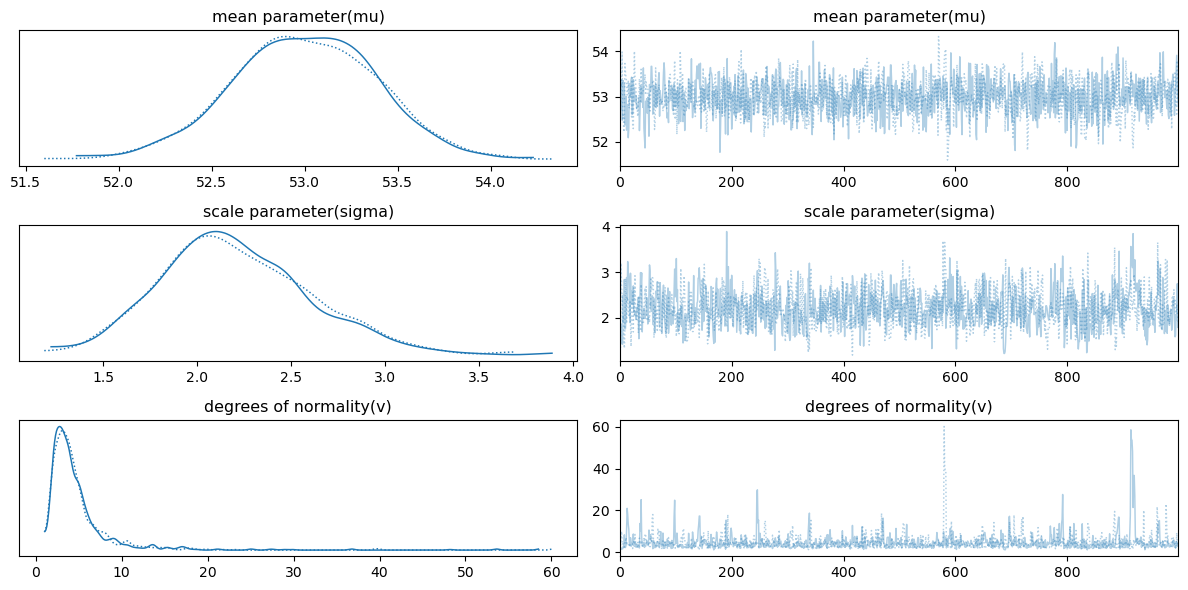

In [86]:
az.plot_trace(idata_t_student); plt.tight_layout()

Comparing it with the previous (1st model)

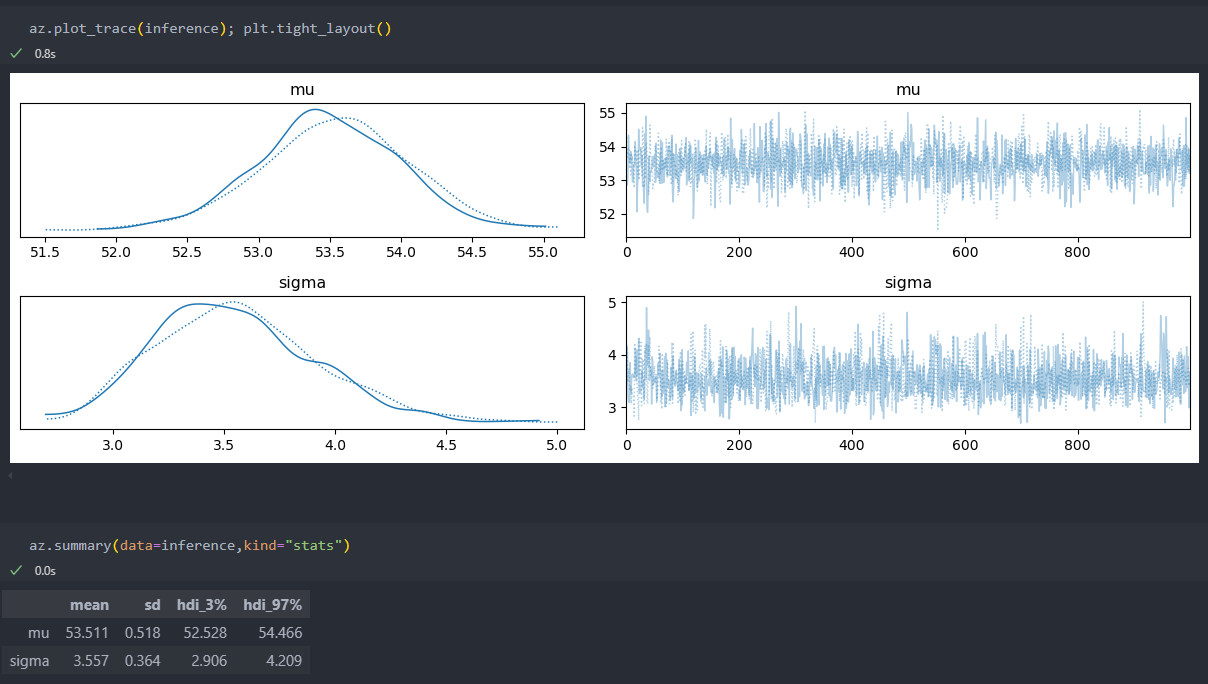

* studentT distribution is less surprised with the 2 values away from the mean. mean v is around 5 suggesting its a heavy tailed distributed variable and not normal, its not approaching infinity

In [90]:
pm.sample_posterior_predictive(idata_t_student, model=student_likelihood_model,extend_inferencedata=True)

Sampling: [Y]


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

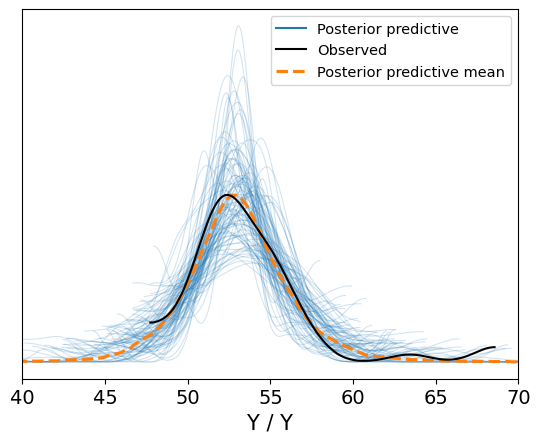

In [95]:
az.plot_ppc(idata_t_student, num_pp_samples=100)
plt.xlim(40, 70)
plt.show()

StudentT distribution allows for more robust estimation of mean and std, because outliers dont cause the mean to follow them or an increase in standard deviation, but instead decrease the value of degrees of normality

#### InferenceData object

In [120]:
inference # thats for the old model with normal likelihood

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [122]:
posterior = inference['posterior'] # returns an xarray dataset!
posterior

<xarray.Dataset>
Dimensions:  (chain: 2, draw: 1000)
Coordinates:
  * chain    (chain) int32 0 1
  * draw     (draw) int32 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
Data variables:
    mu       (chain, draw) float64 53.1 52.97 52.86 53.18 ... 53.24 53.73 53.51
    sigma    (chain, draw) float64 3.587 3.651 4.158 3.294 ... 3.406 3.45 3.42
Attributes:
    created_at:                 2025-02-13T10:50:33.106603
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.8.0
    sampling_time:              16.189280033111572
    tuning_steps:               1000

grabbing 1st draw from chain 0 and 1 

In [135]:
posterior.sel(draw=[0,1,2,3], chain=[0])

<xarray.Dataset>
Dimensions:  (chain: 1, draw: 4)
Coordinates:
  * chain    (chain) int32 0
  * draw     (draw) int32 0 1 2 3
Data variables:
    mu       (chain, draw) float64 53.1 52.97 52.86 53.18
    sigma    (chain, draw) float64 3.587 3.651 4.158 3.294
Attributes:
    created_at:                 2025-02-13T10:50:33.106603
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.8.0
    sampling_time:              16.189280033111572
    tuning_steps:               1000

first 100 draws from all chains

In [136]:
posterior.sel(draw=slice(0,100))

<xarray.Dataset>
Dimensions:  (chain: 2, draw: 101)
Coordinates:
  * chain    (chain) int32 0 1
  * draw     (draw) int32 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99 100
Data variables:
    mu       (chain, draw) float64 53.1 52.97 52.86 53.18 ... 54.18 53.72 53.36
    sigma    (chain, draw) float64 3.587 3.651 4.158 3.294 ... 3.823 3.041 3.878
Attributes:
    created_at:                 2025-02-13T10:50:33.106603
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.8.0
    sampling_time:              16.189280033111572
    tuning_steps:               1000

mean over all draws and chains

In [137]:
posterior.mean()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    mu       float64 53.51
    sigma    float64 3.557

array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

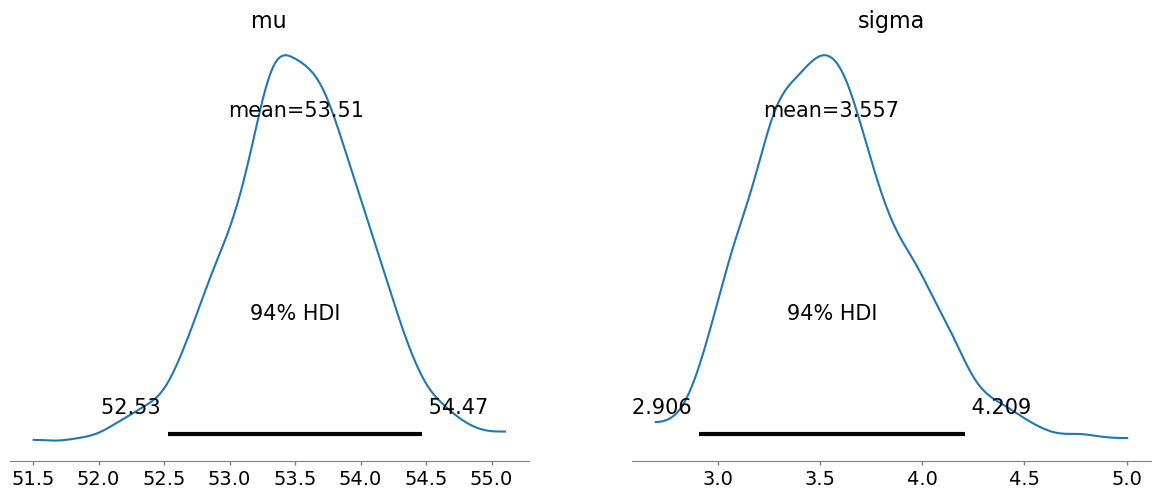

In [144]:
az.plot_posterior(inference, round_to=4)